# 1 - Analysis of the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import emoji # for demojize
import re # for regular expression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer


#### 1.1 - Loading the dataset

In [2]:
df = pd.read_csv("Tweets.csv")

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.shape

(14640, 15)

In [4]:
df[df["tweet_id"] == 570307948171423745]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
11882,570307948171423745,negative,0.6846,Flight Booking Problems,0.6846,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I pay $200 to reactivat...,NaN,2015-02-24 11:43:05 -0800,NaN,Quito
12043,570307948171423745,negative,1.0000,Can't Tell,0.6758,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I pay $200 to reactivat...,NaN,2015-02-24 11:43:05 -0800,NaN,Quito


So, the dataset contains 14640 entries and has 15 columns. The ones that we are interested in are "airline_sentiment" and "text". It represents the sentiment felt by the author of the tweet about US Airlines, 3 possible cases : positive, neutral, negative. At first glance, I do not think that the other columns are relevant in our project as we do not want the model to overfit on for instance Twitter's username or airline.

#### 1.2 - Removing duplications

In [5]:
df[df.duplicated(subset=["tweet_id"], keep=False)].sort_values(by="tweet_id")

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12033,569600137296633856,positive,0.9236,NaN,0.0000,American,positive,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30 -0800,"Caribbean, New York and Miami.",Indiana (East)
14556,569600137296633856,positive,1.0000,NaN,NaN,American,NaN,douglaskgordon,NaN,0,@AmericanAir Thank you.....you do the same!!,NaN,2015-02-22 12:50:30 -0800,"Caribbean, New York and Miami.",Indiana (East)
14543,569601363799359488,negative,1.0000,Flight Attendant Complaints,1.0000,American,NaN,stevereasnors,NaN,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)
12032,569601363799359488,negative,0.9553,Flight Attendant Complaints,0.9553,American,negative,stevereasnors,Flight Attendant Complaints,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)
12031,569621879633391616,negative,1.0000,Customer Service Issue,1.0000,American,negative,salitron78,Customer Service Issue,0,@AmericanAir no response to DM or email yet. ...,NaN,2015-02-22 14:16:53 -0800,on @TheJR,Seoul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12042,570307949614256128,negative,1.0000,Can't Tell,1.0000,American,NaN,ELLLORRAC,NaN,0,@AmericanAir thanks for getting back to me. Bu...,NaN,2015-02-24 11:43:05 -0800,NaN,Central Time (US & Canada)
11880,570308064185880577,neutral,0.6667,NaN,NaN,American,NaN,LancasterPattie,NaN,0,@AmericanAir we've already made other arrangem...,NaN,2015-02-24 11:43:32 -0800,NaN,NaN
12041,570308064185880577,neutral,0.6755,NaN,0.0000,American,NaN,LancasterPattie,NaN,0,@AmericanAir we've already made other arrangem...,NaN,2015-02-24 11:43:32 -0800,NaN,NaN
12040,570308309682675712,negative,1.0000,Customer Service Issue,1.0000,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I even consider continu...,NaN,2015-02-24 11:44:31 -0800,NaN,Quito


Thanks to the "tweet_id", we can see that we have duplications. Exactly, 155 duplications.

In [6]:
df.drop_duplicates(subset=["tweet_id"], keep="first", inplace=True)


In [7]:
df[df.duplicated(subset=["tweet_id"], keep=False)]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


In [8]:
assert(df.shape == (14640-155, 15)), "The shape of the df without duplication is incorrect."
df.shape

(14485, 15)

#### 1.3 - Frequencies of sentiments in the dataset

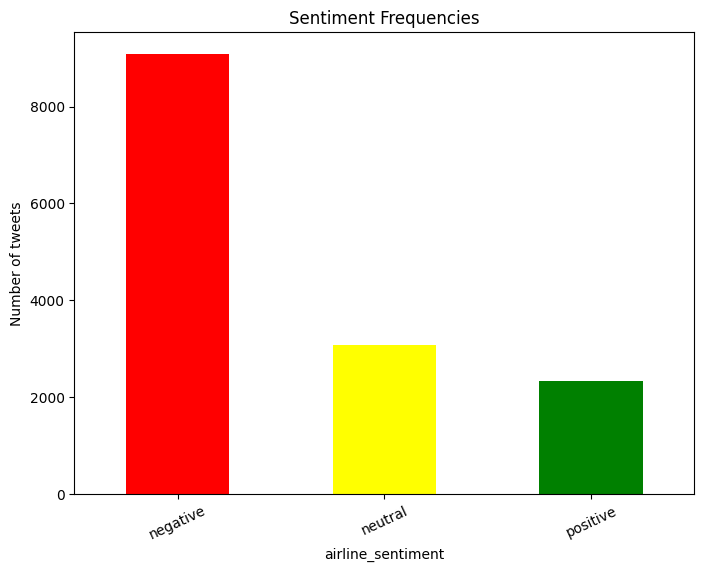

In [9]:
sentiment_counts = df['airline_sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Sentiment Frequencies')
plt.ylabel('Number of tweets')
plt.xticks(rotation=25)
plt.show()

In [10]:
for sentiment, count in sentiment_counts.items():
    print(f"There are {count} tweets with {sentiment} sentiment.")

There are 9082 tweets with negative sentiment.
There are 3069 tweets with neutral sentiment.
There are 2334 tweets with positive sentiment.


As we see, there are a lot of negative tweets about airlines, I think it is pretty normal as people are mostlikely going to say something when it is bad then when it is good. When it is good, it is "normal" for the passenger and does not require to say anything about it. But when it is really really good, they are going to say it. It is the negativity bias (tendency for humans to pay more attention to negative events or experiences compared to positive ones)

For the neutral ones, I do not really know if the dataset is mislabeled. I will try to read some of them later to check.

#### 1.4 - Frequencies of negative sentiment by Airlines

For fun, let's see which company has the most negative tweets. 

In [11]:
sentiment_by_company = df.groupby(['airline', 'airline_sentiment']).size().unstack()

sentiment_by_company

airline_sentiment,negative,neutral,positive
airline,,,
American,1864,433,307
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


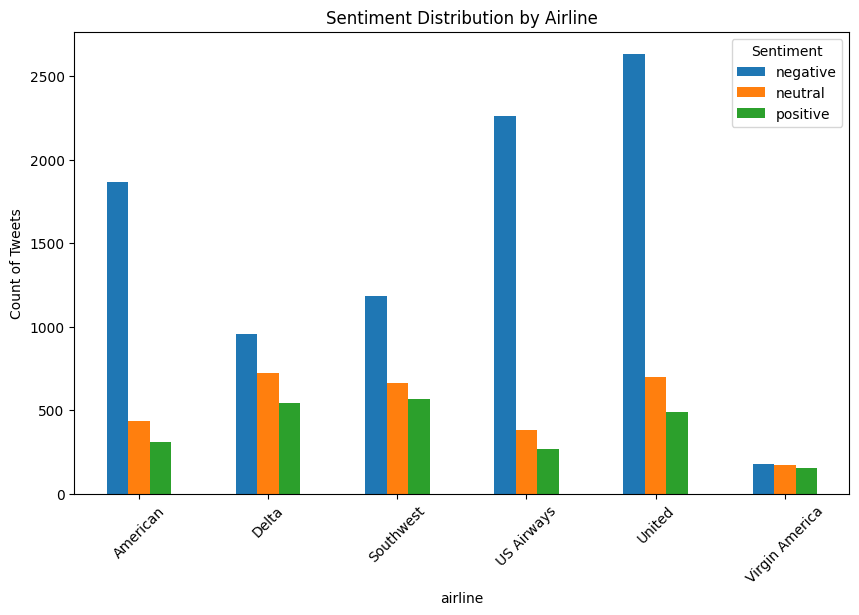

In [12]:
sentiment_by_company.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Sentiment Distribution by Airline')
plt.ylabel('Count of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

In [13]:
negative_tweets_by_company = sentiment_by_company["negative"]
total_tweets_by_company = sentiment_by_company.sum(axis=1)
negative_tweet_rate = (negative_tweets_by_company / total_tweets_by_company).sort_values(ascending=False)

print("Rate of Negative Tweets by Companies:")
print(negative_tweet_rate)

Rate of Negative Tweets by Companies:
airline
US Airways        0.776862
American          0.715822
United            0.688906
Southwest         0.490083
Delta             0.429793
Virgin America    0.359127
dtype: float64


We can see that passengers seem to not like US Airways, American Airlines, United Airlines. Delta Airlines seems to be less hated. About Virgin America, we can't really say anything as there are only around 500 tweets about this company.

#### 1.5 - Length of tweets

In [14]:
negative_lengths = df[df['airline_sentiment'] == 'negative']['text'].str.len()
negative_lengths.mean()

113.93536665932614

In [15]:
negative_word_counts = df[df['airline_sentiment'] == 'negative']['text'].str.split().apply(len)
negative_word_counts.mean()

19.689385597885927

In [16]:
positive_lengths = df[df['airline_sentiment'] == 'positive']['text'].str.len()
positive_lengths.mean()

86.29134532990574

In [17]:
positive_word_counts = df[df['airline_sentiment'] == 'positive']['text'].str.split().apply(len)
positive_word_counts.mean()

14.050985432733505

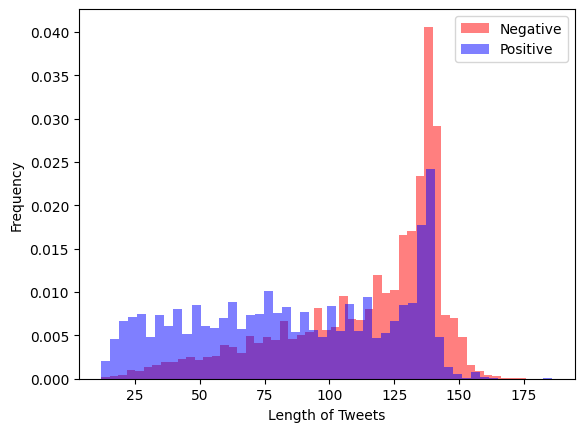

In [18]:
plt.hist(negative_lengths, bins=50, color='red', alpha=0.5, label='Negative', density=True)
plt.hist(positive_lengths, bins=50, color='blue', alpha=0.5, label='Positive', density=True)
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.show()

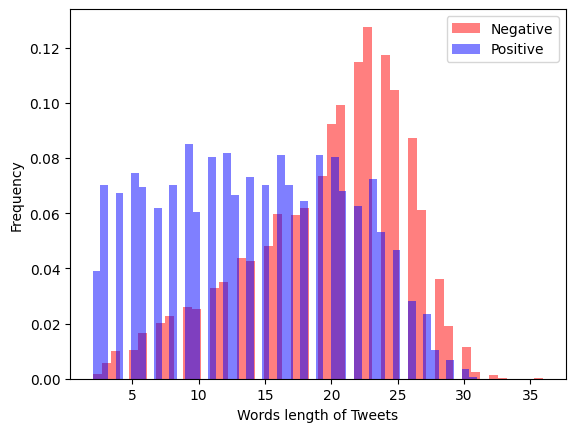

In [19]:
plt.hist(negative_word_counts, bins=50, color='red', alpha=0.5, label='Negative', density=True)
plt.hist(positive_word_counts, bins=50, color='blue', alpha=0.5, label='Positive', density=True)
plt.xlabel('Words length of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We can see that in average, negative tweets have 20 words for 114 characters and positive tweets have 14 words for 86 characters. We may use it as a feature in our model.

# 2 - Pre-processing

#### 2.1 - Removing the useless columns

In [20]:
df = df[["text", "airline_sentiment"]]
df.head(20)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive


#### 2.2 - Converting emojis

For index 18, the emoji ❤️ is important because otherwise we can't understand the analysis of just "I flying". So, now we are going to try to take care of emojis / smileys first.

In [21]:
print(emoji.demojize(df.iloc[18]["text"]))

I :red_heart: flying @VirginAmerica. :smiling_face::thumbs_up:


In [22]:
df['preprocessed_text'] = df['text'].apply(emoji.demojize)
df.head(20)

,text,airline_sentiment,preprocessed_text
0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it's a really big bad thing...
5,@VirginAmerica seriously would pay $30 a fligh...,negative,@VirginAmerica seriously would pay $30 a fligh...
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,@VirginAmerica Really missed a prime opportuni...,neutral,@VirginAmerica Really missed a prime opportuni...
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"@VirginAmerica it was amazing, and arrived an ..."


#### 2.3 - Tokenization and removing stopwords, symbols and company's name

In [23]:
def remove_symbols(text):
    text = text.replace("::", " ") # In case there are two emojis in a row
    
    # Regular expression
    pattern = r'[^a-zA-Z0-9\s]'
    
    # Replace non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    
    return cleaned_text

remove_symbols(df.iloc[18]["preprocessed_text"])

'I redheart flying VirginAmerica smilingface thumbsup'

In [24]:
companies = ['virginamerica', 'united', 'southwest', 'delta', 'usairways', 'americanair', 'usairway', 'southwestair']

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    tokens = [remove_symbols(text) for text in tokens if len(remove_symbols(text)) != 0]
    
    # Remove the first "@" symbol and the company name (first mention in the tweet)
    if "@" in tokens:
        index = tokens.index("@")  
        del tokens[index]  
        if index < len(tokens):
            del tokens[index]  
    
    # Remove stopwords and company name (in case they say the name of the company after the first mention)
    stop_words = set(stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.lower() not in companies]

    # Lemmatize tokens using spaCy because NLTK is not good enough if you do not precise the POS (ex: flying -> flying)
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]
    
    return tokens

df['preprocessed_text'] = df['preprocessed_text'].apply(preprocess_text)
df.head(20)

,text,airline_sentiment,preprocessed_text
0,@VirginAmerica What @dhepburn said.,neutral,"[dhepburn, say]"
1,@VirginAmerica plus you've added commercials t...,positive,"[plus, add, commercial, experience, tacky]"
2,@VirginAmerica I didn't today... Must mean I n...,neutral,"[not, today, must, mean, need, take, another, ..."
3,@VirginAmerica it's really aggressive to blast...,negative,"[really, aggressive, blast, obnoxious, enterta..."
4,@VirginAmerica and it's a really big bad thing...,negative,"[really, big, bad, thing]"
5,@VirginAmerica seriously would pay $30 a fligh...,negative,"[seriously, would, pay, 30, flight, seat, not,..."
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"[yes, nearly, every, time, fly, vx, ear, worm,..."
7,@VirginAmerica Really missed a prime opportuni...,neutral,"[really, miss, prime, opportunity, man, withou..."
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"[well, didntbut]"
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"[amazing, arrive, hour, early, good]"


#### 2.4 - Word cloud

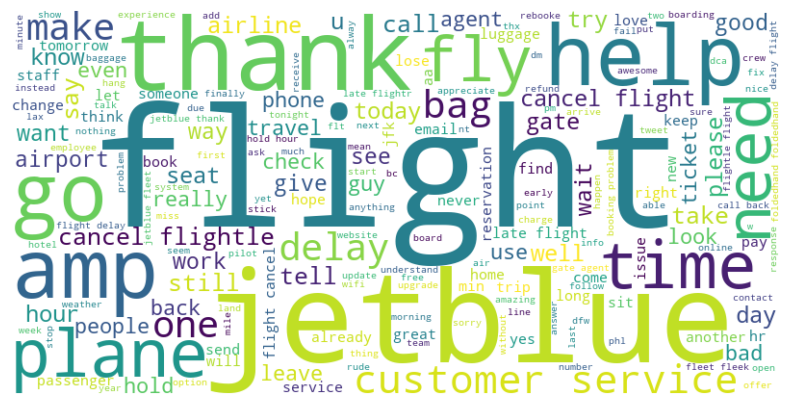

In [25]:
text = ' '.join(df['preprocessed_text'].explode().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

It's to check if there are not the companies' name anymore.

#### 2.5 - Length of tweets

In [26]:
df['tweet_length'] = df['text'].str.len()

df.head(20)

,text,airline_sentiment,preprocessed_text,tweet_length
0,@VirginAmerica What @dhepburn said.,neutral,"[dhepburn, say]",35
1,@VirginAmerica plus you've added commercials t...,positive,"[plus, add, commercial, experience, tacky]",72
2,@VirginAmerica I didn't today... Must mean I n...,neutral,"[not, today, must, mean, need, take, another, ...",71
3,@VirginAmerica it's really aggressive to blast...,negative,"[really, aggressive, blast, obnoxious, enterta...",126
4,@VirginAmerica and it's a really big bad thing...,negative,"[really, big, bad, thing]",55
5,@VirginAmerica seriously would pay $30 a fligh...,negative,"[seriously, would, pay, 30, flight, seat, not,...",135
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"[yes, nearly, every, time, fly, vx, ear, worm,...",79
7,@VirginAmerica Really missed a prime opportuni...,neutral,"[really, miss, prime, opportunity, man, withou...",108
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"[well, didntbut]",47
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"[amazing, arrive, hour, early, good]",80


#### 2.6 -  Transform sentiment to numerical value

Last thing to do is to transform the label into numerical value as : negative 0, neutral 1, positive 2.

In [27]:
df['airline_sentiment'] = df['airline_sentiment'].replace({'negative': 0, 'neutral': 1, 'positive': 2})
df.head(20)

,text,airline_sentiment,preprocessed_text,tweet_length
0,@VirginAmerica What @dhepburn said.,1,"[dhepburn, say]",35
1,@VirginAmerica plus you've added commercials t...,2,"[plus, add, commercial, experience, tacky]",72
2,@VirginAmerica I didn't today... Must mean I n...,1,"[not, today, must, mean, need, take, another, ...",71
3,@VirginAmerica it's really aggressive to blast...,0,"[really, aggressive, blast, obnoxious, enterta...",126
4,@VirginAmerica and it's a really big bad thing...,0,"[really, big, bad, thing]",55
5,@VirginAmerica seriously would pay $30 a fligh...,0,"[seriously, would, pay, 30, flight, seat, not,...",135
6,"@VirginAmerica yes, nearly every time I fly VX...",2,"[yes, nearly, every, time, fly, vx, ear, worm,...",79
7,@VirginAmerica Really missed a prime opportuni...,1,"[really, miss, prime, opportunity, man, withou...",108
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",2,"[well, didntbut]",47
9,"@VirginAmerica it was amazing, and arrived an ...",2,"[amazing, arrive, hour, early, good]",80


In [28]:
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: ' '.join(x))   # useful later for TfidfVectorizer
df.head(20)

,text,airline_sentiment,preprocessed_text,tweet_length
0,@VirginAmerica What @dhepburn said.,1,dhepburn say,35
1,@VirginAmerica plus you've added commercials t...,2,plus add commercial experience tacky,72
2,@VirginAmerica I didn't today... Must mean I n...,1,not today must mean need take another trip,71
3,@VirginAmerica it's really aggressive to blast...,0,really aggressive blast obnoxious entertainmen...,126
4,@VirginAmerica and it's a really big bad thing...,0,really big bad thing,55
5,@VirginAmerica seriously would pay $30 a fligh...,0,seriously would pay 30 flight seat not play re...,135
6,"@VirginAmerica yes, nearly every time I fly VX...",2,yes nearly every time fly vx ear worm go away,79
7,@VirginAmerica Really missed a prime opportuni...,1,really miss prime opportunity man without hat ...,108
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",2,well didntbut,47
9,"@VirginAmerica it was amazing, and arrived an ...",2,amazing arrive hour early good,80


# 3. Modelisation

##### 3.1 - Baseline model (always predicting negative)

In [29]:
X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluation
y_train_pred = [0] * len(X_train)
y_test_pred = [0] * len(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Baseline model on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Baseline model on test set: {accuracy} \n", )

print("Classification Report of Baseline Model :")
print(classification_report(y_test, y_test_pred, zero_division=1))

Accuracy of Baseline model on train set: 0.6223679668622714
Accuracy of Baseline model on test set: 0.6454953400069037 

Classification Report of Baseline Model :
              precision    recall  f1-score   support

           0       0.65      1.00      0.78      1870
           1       1.00      0.00      0.00       605
           2       1.00      0.00      0.00       422

    accuracy                           0.65      2897
   macro avg       0.88      0.33      0.26      2897
weighted avg       0.77      0.65      0.51      2897



#### 3.2 - Logistic Regression with TF-IDF

In [30]:
X = df['preprocessed_text']
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)), 
    ('classifier', LogisticRegression(max_iter=1000)) 
])

# Training the Pipeline
pipeline.fit(X_train, y_train)


# Code before Pipeline
# # TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=5000)
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_test_tfidf = tfidf_vectorizer.transform(X_test)

# # Logistic Regression training
# logreg_model = LogisticRegression(max_iter=1000)
# logreg_model.fit(X_train_tfidf, y_train)



# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Logistic Regression TF-IDF on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Logistic Regression TF-IDF on test set: {accuracy} \n", )

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))


Accuracy of Logistic Regression TF-IDF on train set: 0.8616672419744563
Accuracy of Logistic Regression TF-IDF on test set: 0.7901277183293062 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1870
           1       0.65      0.51      0.57       605
           2       0.79      0.59      0.68       422

    accuracy                           0.79      2897
   macro avg       0.75      0.67      0.71      2897
weighted avg       0.78      0.79      0.78      2897



#### 3.3 - Logistic Regression with TF-IDF & tweet length

In [32]:
X = df[['preprocessed_text', 'tweet_length']]
y = df['airline_sentiment']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline Logistic Regression with TF-IDF & tweet length
pipeline = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('tfidf', TfidfVectorizer(max_features=5000), 'preprocessed_text'),
        ('tweet_length', 'passthrough', ['tweet_length'])
    ], )),  # Drop any remaining columns not specified above
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the Pipeline
pipeline.fit(X_train, y_train)

# Evaluation
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy of Logistic Regression TF-IDF & tweet length on train set:", accuracy)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy of Logistic Regression TF-IDF & tweet length on test set: {accuracy} \n", )

print("Classification Report of Logistic Regression TF-IDF :")
print(classification_report(y_test, y_test_pred))

Accuracy of Logistic Regression TF-IDF & tweet length on train set: 0.8602865032792544
Accuracy of Logistic Regression TF-IDF & tweet length on test set: 0.7849499482222989 

Classification Report of Logistic Regression TF-IDF :
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1870
           1       0.62      0.52      0.57       605
           2       0.77      0.60      0.68       422

    accuracy                           0.78      2897
   macro avg       0.74      0.68      0.70      2897
weighted avg       0.78      0.78      0.78      2897



#### 3.4 - Naive Bayes TF-IDF - Changer la pipeline

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Define pipeline
pipeline = make_pipeline(
    TfidfVectorizer(max_features=5000),
    MultinomialNB()
)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training and prediction
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluation
accuracy_train = accuracy_score(y_train, pipeline.predict(X_train))
print("Accuracy of Naive Bayes TF-IDF on train set:", accuracy_train)

accuracy_test = accuracy_score(y_test, y_pred)
print("Accuracy of Naive Bayes TF-IDF on test set:", accuracy_test)

# Generate classification report on test set
report_test = classification_report(y_test, y_pred)

# Print the classification report for test set
print("Classification Report of Naive Bayes Model TF-IDF :")
print(report_test)

#### Naive Bayes TD-IDF & tweet length 

In [ ]:
from scipy.sparse import hstack

X = df['preprocessed_text'].apply(lambda x: ' '.join(x))  # Convert lists of tokens to strings
y = df['airline_sentiment']

# Split data into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Convert tweet_length to sparse matrix
X_train_tweet_length = df.loc[X_train_text.index, 'tweet_length'].values.reshape(-1, 1)
X_test_tweet_length = df.loc[X_test_text.index, 'tweet_length'].values.reshape(-1, 1)

# Combine TF-IDF matrix with tweet_length for both train and test sets
X_train_features = hstack((X_train_tfidf, X_train_tweet_length))
X_test_features = hstack((X_test_tfidf, X_test_tweet_length))

# Train Naive Bayes classifier
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_features, y_train)

# Predictions
y_pred = naive_bayes.predict(X_test_features)

accuracy = accuracy_score(y_train, logreg_model.predict(X_train_features))
print("Accuracy of Logistic Regression TF-IDF & tweet length on train set:", accuracy)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression TF-IDF & tweet length on test set: {accuracy} \n", )

# Generate classification report on test set
report_test = classification_report(y_test, y_pred)

# Print the classification report for test set
print("Classification Report of Naive Bayes TF-IDF :")
print(report_test)

#### Logistic Regression TF 1-gram and 2-gram

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming 'df' contains the DataFrame with columns "text" and "airline_sentiment"

# Step 1: Extract N-gram Features
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Example: Use trigrams
X_ngrams = vectorizer.fit_transform(df['text'])

# Step 2: Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X_ngrams, df['airline_sentiment'], test_size=0.2, random_state=42)

# Step 3: Fit Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logreg.fit(X_train, y_train)

# Step 4: Evaluate Model
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


#### Logistic Regression TF 1-gram and 2-gram + TD-IDF 4-gram

In [35]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Assuming 'df' contains the DataFrame with columns "text" and "airline_sentiment"

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.2, random_state=42)

# Step 2: Extract CountVectorizer Features on training data
count_vectorizer = CountVectorizer(ngram_range=(1, 2))  # Example: Use bigrams
X_train_count = count_vectorizer.fit_transform(X_train)

# Step 3: Extract TfidfVectorizer Features on training data
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 4))  # Example: Use 4-grams
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Step 4: Concatenate Feature Matrices for training data
X_train_combined = hstack([X_train_count, X_train_tfidf])

# Step 5: Transform test data using trained vectorizers
X_test_count = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Step 6: Concatenate Feature Matrices for test data
X_test_combined = hstack([X_test_count, X_test_tfidf])

# Step 7: Fit Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
logreg.fit(X_train_combined, y_train)

# Step 8: Evaluate Model
y_pred = logreg.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8070417673455299


In [34]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Assuming 'df' contains the DataFrame with columns "text" and "preprocessed_text" and "airline_sentiment"

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['text', 'preprocessed_text']], df['airline_sentiment'], test_size=0.2, random_state=42)

# Step 2: Define the pipeline
pipeline = Pipeline([
    ('vectorizer', ColumnTransformer([
        ('count', CountVectorizer(ngram_range=(1, 2)), 'text'),
        ('tfidf', TfidfVectorizer(ngram_range=(1, 4)), 'text'),
        ('tfidf2', TfidfVectorizer(max_features=5000), 'preprocessed_text')
    ])),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Step 3: Fit the pipeline
pipeline.fit(X_train, y_train)

# Step 4: Evaluate Model
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8087676907145323


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Assuming 'df' contains the DataFrame with columns "text" and "airline_sentiment"

# Define the ranges for n-grams for CountVectorizer and TfidfVectorizer
count_ngram_ranges = [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)]  # Example: Test unigrams, bigrams, and trigrams
tfidf_ngram_ranges = [(1, 1), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4)]  # Example: Test unigrams to 4-grams

for count_ngram_range in count_ngram_ranges:
    for tfidf_ngram_range in tfidf_ngram_ranges:
        # Step 1: Extract CountVectorizer Features
        count_vectorizer = CountVectorizer(ngram_range=count_ngram_range)
        X_count = count_vectorizer.fit_transform(df['text'])

        # Step 2: Extract TfidfVectorizer Features
        tfidf_vectorizer = TfidfVectorizer(ngram_range=tfidf_ngram_range)
        X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

        # Step 3: Concatenate Feature Matrices
        X_combined = hstack([X_count, X_tfidf])

        # Step 4: Prepare Data
        X_train, X_test, y_train, y_test = train_test_split(X_combined, df['airline_sentiment'], test_size=0.2, random_state=42)

        # Step 5: Fit Logistic Regression Model
        logreg = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
        logreg.fit(X_train, y_train)

        # Step 6: Evaluate Model
        y_pred = logreg.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Print the accuracy for the current combination of n-grams
        print(f"CountVectorizer n-gram range: {count_ngram_range}, TfidfVectorizer n-gram range: {tfidf_ngram_range}, Accuracy: {accuracy}")
